<a href="https://colab.research.google.com/github/spulijal13/EmbroynicAgePCA/blob/main/Copy_of_184a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Definition

During development, motor neurons change rapidly as embryonic time progresses. At the molecular level, those changes should be reflected in each cell’s gene expression profile. Our goal is to test whether embryonic age is actually detectable as a structure in high-dimensional single-cell RNA-seq data from motor neurons.

The input to our system is a set of preprocessed `.h5ad` files, one per embryonic age (e09, e10, e12, e13, e14). Each file contains:

* A gene expression matrix (cells × genes) for motor neuron–enriched samples at that age
* Cell-level metadata including the embryonic age

We combine these files into a single `AnnData` object where each row is a cell and each column is a gene, and we add an `embryonic_age` label to each cell. The core question is:

> Do cells from different embryonic ages occupy distinct regions of gene expression space, or are they intermixed?

To answer this, our system performs a full exploratory and statistical analysis:

1. **Quality and composition check.** We verify that the combined dataset is balanced enough across ages and inspect basic properties like the number of cells per age.
2. **Dimensionality reduction.** We apply Principal Component Analysis (PCA) followed by UMAP to compress thousands of genes into a 2D embedding. We color points by embryonic age to see if ages form clusters or gradients.
3. **Quantitative separation metrics.** Beyond eyeballing plots, we compute a silhouette score that measures how well embryonic ages are separated in the UMAP space.
4. **Differential gene expression (DGE).** We identify genes that are significantly up- or down-regulated at each embryonic age compared to the others. These “marker” genes highlight which molecular programs distinguish early from late stages.
5. **Marker visualization.** We visualize top age-specific genes using heatmaps, dotplots, and UMAP overlays to see how their expression patterns track the spatial structure of the embedding.

The outputs of the system are therefore:

* PCA and UMAP plots colored by embryonic age
* A numerical silhouette score measuring age separation
* Ranked lists of age-specific marker genes from DGE
* Marker gene heatmaps, dotplots, and UMAP expression overlays

If embryonic age is truly encoded in the gene expression profiles, we expect to see (i) clear age-structured patterns in PCA/UMAP space and (ii) coherent sets of genes whose expression changes systematically with age. If we instead find no meaningful clustering or only weak DGE, that would suggest embryonic age is not strongly separable in this dataset or that other factors (batch, technical noise, subtypes) dominate the structure.

We need to show that this is novel. This is unsupervised clustering.


1) Setup: mount Drive and install packages

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install scanpy anndata

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 101.3 MB/s eta 0:00:00


2) Load and integrate .h5ad files, annotate embryonic age

In [ ]:
import os
import glob
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/184a RNA data"
file_paths = sorted(glob.glob(os.path.join(data_dir, "*_integrated.h5ad")))

adatas = []
for path in file_paths:
    age_label = os.path.basename(path).split("_")[0]
    tmp = sc.read_h5ad(path)
    tmp.obs["embryonic_age"] = age_label
    adatas.append(tmp)

adata = ad.concat(adatas, join="outer")
adata.obs_names_make_unique()
adata.obs["embryonic_age"] = adata.obs["embryonic_age"].astype("category")
adata

AnnData object with n_obs × n_vars = 99989 × 29184
    obs: 'age', '10X', 'sample_type', 'Sequencer', 'Flowcell', 'Collection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'leiden', 'doublets', 'predicted_labels', 'majority_voting', 'conf_score', 'celltypes', 'over_clustering', 'batch_id', 'embryonic_age'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    layers: 'counts'

3) Basic QC: cell counts per embryonic age

AnnData object with n_obs × n_vars = 99989 × 29184
    obs: 'age', '10X', 'sample_type', 'Sequencer', 'Flowcell', 'Collection', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'batch', 'leiden', 'doublets', 'predicted_labels', 'majority_voting', 'conf_score', 'celltypes', 'over_clustering', 'batch_id', 'embryonic_age'
    obsm: 'X_pca', 'X_scanorama', 'X_umap'
    layers: 'counts'
embryonic_age
e09    20821
e10    29409
e11    22702
e12    10031
e13    12868
e14     4158
Name: count, dtype: int64


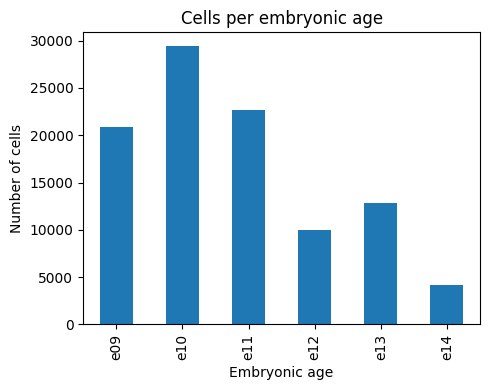

In [ ]:
print(adata)

age_counts = adata.obs["embryonic_age"].value_counts().sort_index()
print(age_counts)

plt.figure(figsize=(5, 4))
age_counts.plot(kind="bar")
plt.xlabel("Embryonic age")
plt.ylabel("Number of cells")
plt.title("Cells per embryonic age")
plt.tight_layout()
plt.show()

4) Preprocessing: normalize, log-transform, HVGs, scale

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3")
adata = adata[:, adata.var["highly_variable"]]

sc.pp.scale(adata, max_value=10)
adata

ImportError: Please install skmisc package via `pip install --user scikit-misc

5) PCA, neighbors, UMAP, and age-colored plots

In [ ]:
sc.set_figure_params(dpi=100)

sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

sc.pl.pca(adata, color="embryonic_age")
sc.pl.umap(adata, color="embryonic_age")

6) Quantify age separation with silhouette score on UMAP

In [ ]:
from sklearn.metrics import silhouette_score

embedding = adata.obsm["X_umap"]
labels = adata.obs["embryonic_age"].cat.codes.values

silhouette = silhouette_score(embedding, labels)
print("Silhouette score for embryonic age on UMAP embedding:", silhouette)

7) Differential gene expression by embryonic age

In [ ]:
sc.tl.rank_genes_groups(
    adata,
    groupby="embryonic_age",
    method="wilcoxon",
    n_genes=50
)

sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

8) Marker heatmap and dotplot for top age-specific genes

In [ ]:
sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=10,
    groupby="embryonic_age",
    show_gene_labels=True,
    swap_axes=True
)

sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=10,
    groupby="embryonic_age"
)

9) UMAP overlays of top marker genes

In [ ]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names

top_genes = []
for g in groups:
    top_genes.extend(list(result["names"][g][:3]))

top_genes = list(dict.fromkeys(top_genes))

sc.pl.umap(
    adata,
    color=top_genes,
    ncols=4
)